In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error

### Bootstrap
("sampling with replacement")

<div>
<img src="bootstrap.png" width="600"/>
</div>

**Key Facts**:
* Ideal bootstrap samples: \($N^N$\) possible resampled datasets.
* Number of replications: Choice of \($B$\) affects how much variability is captured.
* Resampling method: Uniform distribution sampling with replacement is commonly used.

**Variance**:
$$ \textrm{SE}^2(\hat{\theta})=\frac{\sum_{b=1}^B\left(\hat{\theta}_b^*-\bar{\theta}^*\right)^2}{B-1} $$
where $\theta$ is the model's parameter.

In [21]:
np.random.seed(42)

# Synthetic data (2D inputs -> 1D output)
n_samples = 150
x1 = np.random.uniform(-2, 2, n_samples)
x2 = np.random.uniform(-2, 2, n_samples)

# True relationship (quadratic + interaction)
y_true = 1.5 + 2*x1 - 1.2*x2 + 0.8*x1*x2 - 0.5*x1**2 + 0.3*x2**2
y = y_true + 0.8 * np.random.randn(n_samples)  # add noise

X = np.column_stack([x1, x2])

# Polynomial regression
poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

coef_nominal = model.coef_
coef_nominal[0] = model.intercept_  # adjust intercept placement
feature_names = poly.get_feature_names_out(["x1", "x2"])

### Synthetic Data
**Formula**:
$$y=b_0+b_1x_1+b_2x_2+b_3x_1x_2+b_4x_1^2+b_5x_2^2+\epsilon$$
where $\epsilon$ is artificial noise.

In [22]:
# Create grid for visualization
x1_grid = np.linspace(X[:,0].min(), X[:,0].max(), 30)
x2_grid = np.linspace(X[:,1].min(), X[:,1].max(), 30)
X1_grid, X2_grid = np.meshgrid(x1_grid, x2_grid)

# Prepare grid for prediction
X_grid_poly = poly.transform(np.c_[X1_grid.ravel(), X2_grid.ravel()])
y_grid = model.predict(X_grid_poly).reshape(X1_grid.shape)

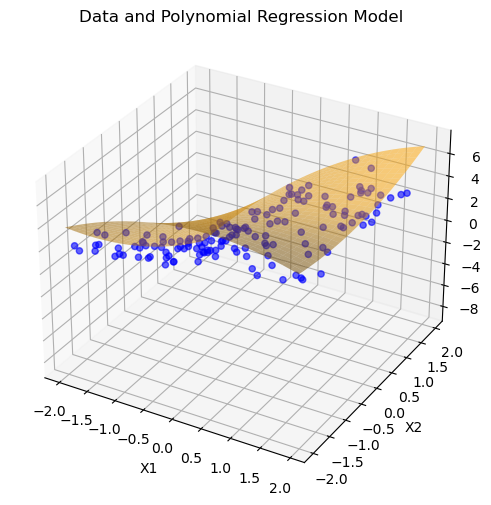

In [23]:
# Plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Scatter the original data
ax.scatter(X[:,0], X[:,1], y, color='blue', alpha=0.6, label="Data")

# Plot regression surface
ax.plot_surface(X1_grid, X2_grid, y_grid, color='orange', alpha=0.5, label="Regression Surface")

# Labels
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("y")
plt.title("Data and Polynomial Regression Model")

plt.show()

In [24]:
n_boot = 1000
boot_coefs = []

for _ in range(n_boot):
    X_res, y_res = resample(X, y)
    X_res_poly = poly.transform(X_res)
    m_boot = LinearRegression().fit(X_res_poly, y_res)
    coef_boot = m_boot.coef_
    coef_boot[0] = m_boot.intercept_
    boot_coefs.append(coef_boot)

boot_coefs = np.array(boot_coefs)

# Compute bootstrap stats
coef_se = boot_coefs.std(axis=0)
coef_var = boot_coefs.var(axis=0)

stats_df = pd.DataFrame({
    "Coefficient": feature_names,
    "Nominal": coef_nominal,
    "Bootstrap_SE": coef_se,
    "Bootstrap_Var": coef_var
})

print(stats_df)

  Coefficient   Nominal  Bootstrap_SE  Bootstrap_Var
0           1  1.622978      0.126187       0.015923
1          x1  2.048723      0.051759       0.002679
2          x2 -1.246714      0.061381       0.003768
3        x1^2 -0.516688      0.051426       0.002645
4       x1 x2  0.806362      0.049880       0.002488
5        x2^2  0.268952      0.052438       0.002750


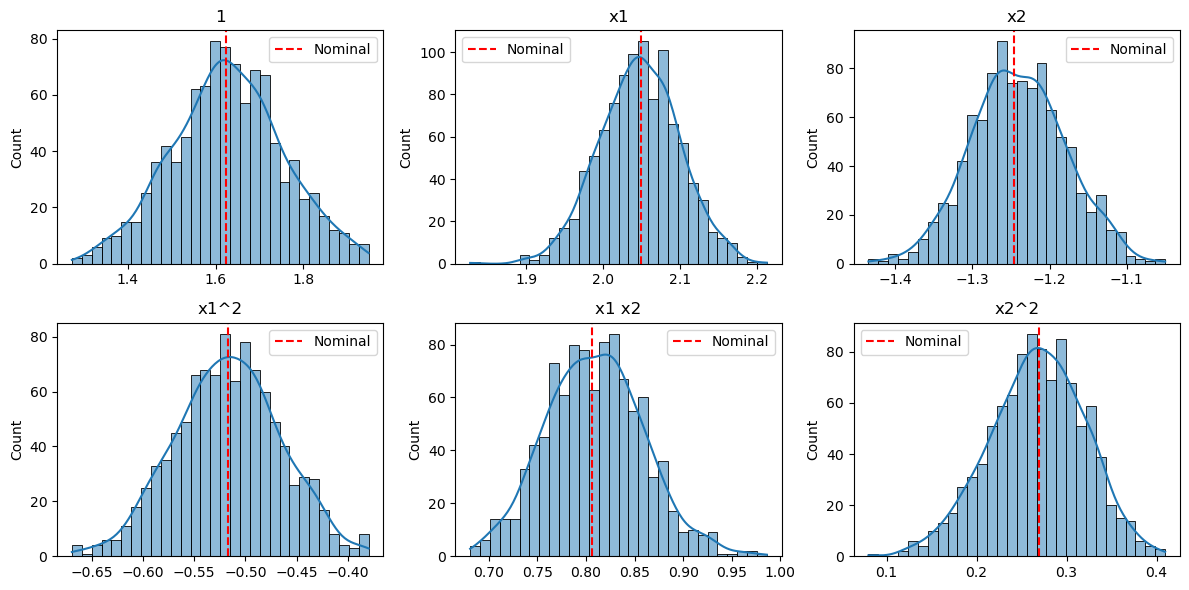

In [25]:
n_coef = len(feature_names)
fig, axes = plt.subplots(n_coef//3, 3, figsize=(12, 3*(n_coef//3)))
axes = axes.flatten()

for i in range(n_coef):
    sns.histplot(boot_coefs[:, i], bins=30, kde=True, ax=axes[i])
    axes[i].axvline(coef_nominal[i], color="red", linestyle="--", label="Nominal")
    axes[i].set_title(f"{feature_names[i]}")
    axes[i].legend()

plt.tight_layout()
plt.show()

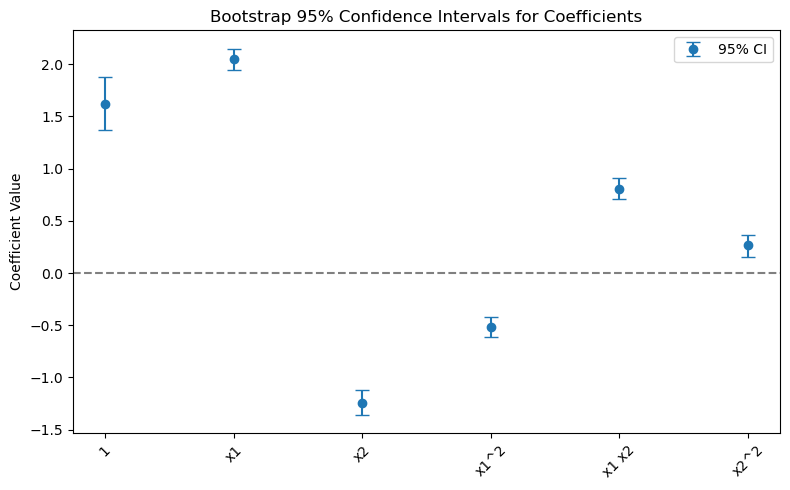

In [26]:
conf_intervals = np.percentile(boot_coefs, [2.5, 97.5], axis=0).T

fig, ax = plt.subplots(figsize=(8, 5))
ax.errorbar(range(len(coef_nominal)), coef_nominal, 
            yerr=[coef_nominal - conf_intervals[:, 0], conf_intervals[:, 1] - coef_nominal], 
            fmt='o', capsize=5, label="95% CI")
ax.axhline(0, color='gray', linestyle='--')
ax.set_xticks(range(len(feature_names)))
ax.set_xticklabels(feature_names, rotation=45)
ax.set_ylabel("Coefficient Value")
ax.set_title("Bootstrap 95% Confidence Intervals for Coefficients")
ax.legend()
plt.tight_layout()
plt.show()

In [27]:
B = 500  # number of bootstrap samples
n = len(y)

# Prepare polynomial features for nominal fit
poly2 = PolynomialFeatures(degree=2, include_bias=False)
poly3 = PolynomialFeatures(degree=3, include_bias=False)

X_poly2 = poly2.fit_transform(X)
X_poly3 = poly3.fit_transform(X)

# Nominal fits
model2_nom = LinearRegression().fit(X_poly2, y)
model3_nom = LinearRegression().fit(X_poly3, y)

# Nominal prediction errors
err2_nom = y - model2_nom.predict(X_poly2)
err3_nom = y - model3_nom.predict(X_poly3)

# Bootstrap errors storage
errs_2 = np.zeros((B, n))
errs_3 = np.zeros((B, n))

for b in range(B):
    # Bootstrap resample
    Xb, yb = resample(X, y, replace=True, n_samples=n)
    
    # 2nd order
    model2 = LinearRegression().fit(poly2.transform(Xb), yb)
    errs_2[b] = y - model2.predict(X_poly2)
    
    # 3rd order
    model3 = LinearRegression().fit(poly3.transform(Xb), yb)
    errs_3[b] = y - model3.predict(X_poly3)

In [28]:
# Compute bootstrap statistics of errors
se_err2 = errs_2.std(axis=0, ddof=1)
se_err3 = errs_3.std(axis=0, ddof=1)

var_err2 = se_err2**2
var_err3 = se_err3**2

# --- Print summary ---
print("2nd-order model:")
print(" Nominal RMSE:", np.sqrt(mean_squared_error(y, model2_nom.predict(X_poly2))))
print(" Mean SE of errors:", se_err2.mean())
print(" Mean variance of errors:", var_err2.mean())

print("\n3rd-order model:")
print(" Nominal RMSE:", np.sqrt(mean_squared_error(y, model3_nom.predict(X_poly3))))
print(" Mean SE of errors:", se_err3.mean())
print(" Mean variance of errors:", var_err3.mean())

2nd-order model:
 Nominal RMSE: 0.7354249911055974
 Mean SE of errors: 0.1426416350318365
 Mean variance of errors: 0.02270581607414032

3rd-order model:
 Nominal RMSE: 0.7012030774125123
 Mean SE of errors: 0.17849003537784558
 Mean variance of errors: 0.03628970047098281


### Jackknife vs. Bootstrap
|Jackknife | Bootstrap |
|:----------|:----------|
| Leave-one-out resampling | Sampling with replacement |
| Computationally lighter, deterministic | Heavier, results vary across runs |
| Conservative, larger SEs | More accurate, handles skew/skewed data better |
| Good for bias reduction, small samples | Broad applications (SE, CI, bias, prediction error) |

**Analogy**: Jackknife = small handy tool; Bootstrap = full workshop of tools.

### Reference
**Bootstrap**:
* StatQuest with Josh Starmer. (2021). Bootstapping Main Ideas!!! [Video]. YouTube. https://www.youtube.com/watch?v=Xz0x-8-cgaQ.
* Huang, H. Jackknife-Bootstrap [Lecture notes]. U. C. Berkeley. https://www.stat.berkeley.edu/~hhuang/STAT152/Jackknife-Bootstrap.pdf.
* Glen, S. (2019). Resampling Methods: Bootstrap vs Jackknife [Artivle]. Data Science Central. https://www.datasciencecentral.com/resampling-methods-comparison/.